In [4]:
using Pkg
Pkg.update()

    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/JuDO-dev/AirBorne.jl#dev`
    Updating `~/Documents/uni-4/FYP/fyp_repo/Project.toml`
  [4a232ea9] ~ AirBorne v1.0.1-DEV `https://github.com/JuDO-dev/AirBorne.jl#dev#dev` ⇒ v1.0.1-DEV `https://github.com/JuDO-dev/AirBorne.jl#dev#dev`
    Updating `~/Documents/uni-4/FYP/fyp_repo/Manifest.toml`
  [4a232ea9] ~ AirBorne v1.0.1-DEV `https://github.com/JuDO-dev/AirBorne.jl#dev#dev` ⇒ v1.0.1-DEV `https://github.com/JuDO-dev/AirBorne.jl#dev#dev`
  [4c555306] ↑ ArrayLayouts v1.9.3 ⇒ v1.9.4
  [d8a4904e] ↑ MutableArithmetics v1.4.4 ⇒ v1.4.5
  [1e6cf692] ↑ TestEnv v1.101.1 ⇒ v1.102.0
Precompiling project...
  ✓ Optim → OptimMOIExt
  ✓ StateSpaceModels
  ✓ AirBorne
  3 dependencies successfully precompiled in 91 seconds. 341 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version
  1 dependency had output during precompilat

In [5]:
Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")

    Updating git-repo `https://github.com/JuDO-dev/AirBorne.jl#dev`
   Resolving package versions...
  No Changes to `~/Documents/uni-4/FYP/fyp_repo/Project.toml`
  No Changes to `~/Documents/uni-4/FYP/fyp_repo/Manifest.toml`


# Imports

In [6]:
using AirBorne.Engines.DEDS
using AirBorne
using AirBorne.ETL.YFinance: get_interday_data, get_chart_data, parse_intraday_raw_data
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data, Order, place_order!, executeOrder_CA!
using AirBorne.Strategies.FALM: falm_initialize!, falm_trading_logic!
using AirBorne.Forecast
using Dates
using AirBorne.Structures: summarizePerformance,TimeEvent, ContextTypeA
using AirBorne.ETL.AssetValuation: stockValuation
using DotMaps


# Get Data

In [3]:
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
tickers = ["AAPL", "MSFT", "ISRG", "BABA", "SPY", "EFA", "TLT", "GLD"]
stocks = get_interday_data(tickers, unix("2021-01-01"), unix("2024-01-01"))

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,129.41,133.61,126.76,133.52,143301900,2021-01-04T10:30:00,1609770600,NMS,America/New_York,USD,AAPL,NMS/AAPL
2,131.01,131.74,128.43,128.89,97664900,2021-01-05T10:30:00,1609857000,NMS,America/New_York,USD,AAPL,NMS/AAPL
3,126.6,131.05,126.38,127.72,155088000,2021-01-06T10:30:00,1609943400,NMS,America/New_York,USD,AAPL,NMS/AAPL
4,130.92,131.63,127.86,128.36,109578200,2021-01-07T10:30:00,1610029800,NMS,America/New_York,USD,AAPL,NMS/AAPL
5,132.05,132.63,130.23,132.43,105158200,2021-01-08T10:30:00,1610116200,NMS,America/New_York,USD,AAPL,NMS/AAPL
6,128.98,130.17,128.5,129.19,100384500,2021-01-11T10:30:00,1610375400,NMS,America/New_York,USD,AAPL,NMS/AAPL
7,128.8,129.69,126.86,128.5,91951100,2021-01-12T10:30:00,1610461800,NMS,America/New_York,USD,AAPL,NMS/AAPL
8,130.89,131.45,128.49,128.76,88636800,2021-01-13T10:30:00,1610548200,NMS,America/New_York,USD,AAPL,NMS/AAPL
9,128.91,131.0,128.76,130.8,90221800,2021-01-14T10:30:00,1610634600,NMS,America/New_York,USD,AAPL,NMS/AAPL


# Initialise Algorithm

In [55]:
using Suppressor
linear = LinearForecaster(7; reparameterise_window = 10)
arima = ArimaForecaster(2, 1, 1; reparameterise_window = 10)
forecaster = CombinedForecaster([linear, arima], [0.18, 0.82])

# Initialize the FALM strategy
demo_falm_init!(context) = falm_initialize!(
    context;
    initialCapital = 10^4,
    lookahead = 3,
    lpm_order = 3.0,
    max_lookback = 10,
    tickers = tickers,
    assetIDs = unique(stocks.assetID),
    transactionCost = 0.02,
    httype = :average,
    min_alloc_threshold = 1.0,
    min_returns_threshold= 0.0005,
    forecaster = forecaster
) 

demo_falm_logic!(context, data) = falm_trading_logic!(context, data)

evaluationEvents = [TimeEvent(t, "data_transfer") for t in sort(unique(stocks.date); rev=true)]


# Run the strategy
feeStructure=Vector{Dict}([Dict("FeeName" => "SaleCommission", "fixedPrice" => 0.0, "variableRate" => 0.02)])
singleExecutionFun(context, order, data) = executeOrder_CA!(context, order, data;defaultFeeStructures=feeStructure,partialExecutionAllowed=false)
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true, executeOrder=singleExecutionFun)
falm_context = @suppress AirBorne.Engines.DEDS.run(
    stocks,
    demo_falm_init!,
    demo_falm_logic!,
    my_execute_orders!,
    expose_data;
    audit=true,
    verbose=false,
    initialEvents=evaluationEvents,
)

dollar_symbol = "FEX/USD"

usdData = deepcopy(stocks[stocks.symbol .== falm_context.extra.tickers[1], :])
usdData[!, "assetID"] .= dollar_symbol
usdData[!, "exchangeName"] .= "FEX"
usdData[!, "symbol"] .= "USD"
usdData[!, [:close, :high, :low, :open]] .= 1.0
usdData[!, [:volume]] .= 0
OHLCV_data = vcat(stocks, usdData)

results = summarizePerformance(OHLCV_data, falm_context; includeAccounts=false, riskFreeRate=0.04)




Summarizing performance


Row,date,type,portfolio,account,stockValue,dollarValue,return,mean_return,std_return,sharpe,drawdown,annual_return,total_vol,total_sharpe
,DateTime,String,Any,Any,Dict…?,Float64,Union…,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-01-04T10:30:00,start,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>227.85, ""NMS/ISRG""=>266.667, ""NMS/AAPL""=>129.41, ""NGM/TLT""=>157.54, ""PCX/GLD""=>182.33, ""NMS/MSFT""=>217.69, ""PCX/SPY""=>368.79, ""PCX/EFA""=>73.34, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.0599284,0.00953283,2.0905
2,2021-01-04T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>227.85, ""NMS/ISRG""=>266.667, ""NMS/AAPL""=>129.41, ""NGM/TLT""=>157.54, ""PCX/GLD""=>182.33, ""NMS/MSFT""=>217.69, ""PCX/SPY""=>368.79, ""PCX/EFA""=>73.34, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.0599284,0.00953283,2.0905
3,2021-01-05T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>240.4, ""NMS/ISRG""=>268.35, ""NMS/AAPL""=>131.01, ""NGM/TLT""=>156.37, ""PCX/GLD""=>182.87, ""NMS/MSFT""=>217.9, ""PCX/SPY""=>371.33, ""PCX/EFA""=>74.1, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.0599284,0.00953283,2.0905
4,2021-01-06T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>227.61, ""NMS/ISRG""=>264.263, ""NMS/AAPL""=>126.6, ""NGM/TLT""=>153.16, ""PCX/GLD""=>179.9, ""NMS/MSFT""=>212.25, ""PCX/SPY""=>373.55, ""PCX/EFA""=>74.95, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.0599284,0.00953283,2.0905
5,2021-01-07T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>226.9, ""NMS/ISRG""=>269.403, ""NMS/AAPL""=>130.92, ""NGM/TLT""=>151.81, ""PCX/GLD""=>179.48, ""NMS/MSFT""=>218.29, ""PCX/SPY""=>379.1, ""PCX/EFA""=>75.03, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.0599284,0.00953283,2.0905
6,2021-01-08T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>10000))))","Dict(""NYQ/BABA""=>236.19, ""NMS/ISRG""=>272.917, ""NMS/AAPL""=>132.05, ""NGM/TLT""=>151.32, ""PCX/GLD""=>173.34, ""NMS/MSFT""=>219.62, ""PCX/SPY""=>381.26, ""PCX/EFA""=>75.73, ""FEX/USD""=>1.0)",10000.0,0.0,0.0,0.0,-Inf,0.0,0.0599284,0.00953283,2.0905
7,2021-01-11T10:30:00,data_transfer,"Dict{Any, Any}(""NYQ/BABA""=>0.0, ""NMS/ISRG""=>0.0, ""NMS/AAPL""=>0.0, ""NGM/TLT""=>0.0, ""PCX/GLD""=>0.0, ""NMS/MSFT""=>0.0, ""PCX/SPY""=>0.0, ""PCX/EFA""=>0.0, ""FEX/USD""=>10000)","DotMap(Dict{Symbol, Any}(:usd=>DotMap(Dict{Symbol, Any}(:currency=>""FEX/USD"", :balance=>1

# Compare With Benchmarks

In [17]:
using Plots, Statistics, DelimitedFiles

function get_VaR(data, alpha=0.05)
    returns = diff(data) ./ data[1:end-1]
    return round(quantile(returns * -100, alpha); digits=2)
end

function get_ES(data, alpha=0.05)
    returns = diff(data) ./ data[1:end-1]
    return mean(returns[returns .<= quantile(returns, alpha)])
end
function get_annual_returns(data)
    returns = diff(data) ./ data[1:end-1]
    return round(((1 + mean(returns))^252 - 1) * 100; digits=2)
end
function get_volatility(data)
    return round(std(diff(data) ./ data[1:end-1]) * 100; digits=2)
end
function get_sharpe(data, riskFreeRate=0.04)
    return round((get_annual_returns(data) - riskFreeRate) / get_volatility(data); digits=2)
end
function get_max_drawdown(data)
    returns = diff(data) ./ data[1:end-1]
    cum_returns = cumprod(1 .+ returns)
    max_drawdown = 0
    for i in 1:length(cum_returns)
        for j in i:length(cum_returns)
            drawdown = (cum_returns[j] - cum_returns[i]) / cum_returns[i]
            if drawdown < max_drawdown
                max_drawdown = drawdown
            end
        end
    end
    return round(max_drawdown * 100; digits=2)
end


test_tickers = ["^GSPC", "AAPL", "MSFT", "ISRG", "BABA", "SPY", "EFA", "TLT", "GLD"]
portfolio_tickers = ["AAPL", "MSFT", "ISRG", "BABA", "SPY", "EFA", "TLT", "GLD"]
test_data = get_interday_data(test_tickers, unix("2021-01-01"), unix("2024-01-01"))

initial_investment = 10^4

irx = test_data[test_data.symbol .== "^IRX", :close]
irx_returns = diff(irx) ./ irx[1:end-1]
irx_prices = cumprod(1 .+ irx_returns) .* initial_investment

sp500 = test_data[test_data.symbol .== "^GSPC", :close]
sp500_returns = diff(sp500) ./ sp500[1:end-1]
sp500_prices = cumprod(1 .+ sp500_returns) .* initial_investment

dates = results.date
ticks = Dates.format.(dates, "dd-mm-yyyy")
step_size = round(Int, length(results.dollarValue) / 10)
date_idx =1:step_size:length(ticks)

p = plot(results.dollarValue, label="FALM - Combined Forecast", size=(1000, 500), title="FALM Portfolio Optimisation Performance, Combined Forecast", xlabel="Date", ylabel="Portfolio Value", leftmargin=5Plots.mm, bottommargin=10Plots.mm, 
legend=:topleft, grid=:on, frame=:box, xrotation=45, xticks=(1:step_size:length(results.dollarValue),ticks[end-length(results.dollarValue)+1:step_size:end]),
linestyle=:dash, linewidth=2)

open("falm_plots/FALM_Portfolio_Performance_combined.txt", "w") do f
    writedlm(f, results.dollarValue)
end

# p = plot(sp500_prices, label="SP500", title="Portfolio Performance", xlabel="Days", ylabel="Value", legend=:topleft)

homogenous_weight = 1.0 / length(portfolio_tickers)
homogenous_prices = nothing
for ticker in portfolio_tickers
    stock = test_data[test_data.symbol .== ticker, :close]
    stock_returns = diff(stock) ./ stock[1:end-1]
    stock_prices = cumprod(1 .+ stock_returns) .* initial_investment
    if ticker in ["AAPL", "SPY"]
        plot!(p, stock_prices, label=ticker)    
    end
    if isnothing(homogenous_prices)
        homogenous_prices = (stock_prices .* homogenous_weight)
    else
        homogenous_prices .+= (stock_prices .* homogenous_weight)
    end
end

#Plot the results
# plot!(p, sp500_prices, label="S&P 500")
# plot!(p, irx_prices, label="IRX")
plot!(p, homogenous_prices, label="Homogenous")
display(p)
savefig(p, "falm_plots/FALM_Portfolio_Performance_combined.svg")

println("FALM Portfolio Performance")
println("VaR: ", get_VaR(results.dollarValue))
println("ES: ", get_ES(results.dollarValue))
println("Annual Returns: ", get_annual_returns(results.dollarValue))
println("Sharpe Ratio: ", get_sharpe(results.dollarValue))
println("Max Drawdown: ", get_max_drawdown(results.dollarValue))
println("Volatility: ", std(diff(results.dollarValue) ./ results.dollarValue[1:end-1]))


UndefVarError: UndefVarError: `results` not defined

Running FALM with avg_falm_init!
FALM Portfolio Performance
VaR: -1.77
ES: -0.024595615160756593
Annual Returns: 4.68
Sharpe Ratio: 4.18
Max Drawdown: -30.18
Volatility: 0.01105524558240738
Running FALM with min_falm_init!
FALM Portfolio Performance
VaR: -1.66
ES: -0.0225352518205841
Annual Returns: 2.56
Sharpe Ratio: 2.47
Max Drawdown: -24.56
Volatility: 0.010201562555672287
Running FALM with max_falm_init!
FALM Portfolio Performance
VaR: -1.68
ES: -0.023561364479674985
Annual Returns: 2.25
Sharpe Ratio: 2.1
Max Drawdown: -29.29
Volatility: 0.01049269856811151


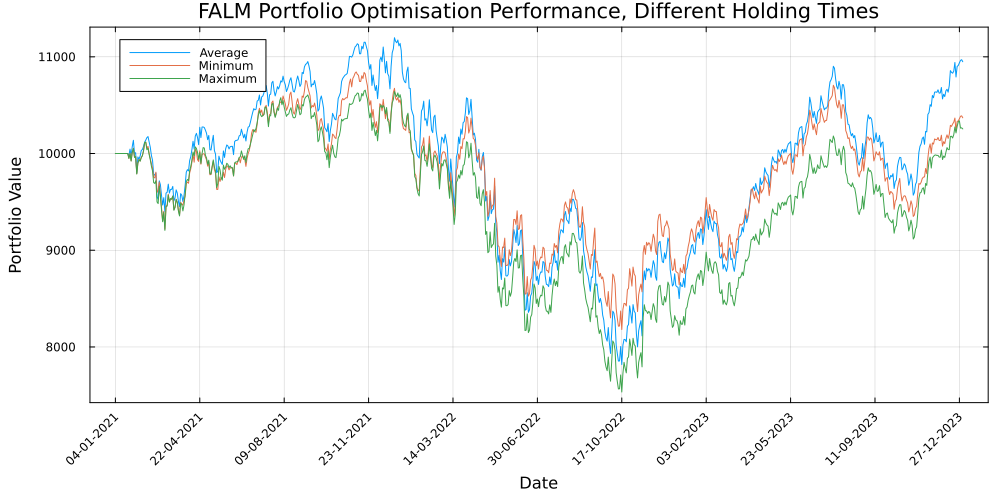

217

In [18]:
using Suppressor
using Latexify
using DelimitedFiles

linear = LinearForecaster(7; reparameterise_window = 10)
arima = ArimaForecaster(2, 1, 1; reparameterise_window = 10)
forecaster = CombinedForecaster([linear, arima], [0.18, 0.82])

# Initialize the FALM strategy
avg_falm_init!(context) = falm_initialize!(
    context;
    initialCapital = 10^4,
    lookahead = 3,
    lpm_order = 3.0,
    max_lookback = 10,
    tickers = tickers,
    assetIDs = unique(stocks.assetID),
    transactionCost = 0.02,
    httype = :average,
    min_alloc_threshold = 1.0,
    min_returns_threshold= 0.0005,
    forecaster = forecaster
) 
min_falm_init!(context) = falm_initialize!(
    context;
    initialCapital = 10^4,
    lookahead = 3,
    lpm_order = 3.0,
    max_lookback = 10,
    tickers = tickers,
    assetIDs = unique(stocks.assetID),
    transactionCost = 0.02,
    httype = :minimum,
    min_alloc_threshold = 1.0,
    min_returns_threshold= 0.0005,
    forecaster = forecaster
) 

max_falm_init!(context) = falm_initialize!(
    context;
    initialCapital = 10^4,
    lookahead = 3,
    lpm_order = 3.0,
    max_lookback = 10,
    tickers = tickers,
    assetIDs = unique(stocks.assetID),
    transactionCost = 0.02,
    httype = :maximum,
    min_alloc_threshold = 1.0,
    min_returns_threshold= 0.0005,
    forecaster = forecaster
)

function augment_data(data)
    dollar_symbol = "FEX/USD"
    usdData = deepcopy(data[data.symbol .== data.symbol[1], :])
    usdData[!, "assetID"] .= dollar_symbol
    usdData[!, "exchangeName"] .= "FEX"
    usdData[!, "symbol"] .= "USD"
    usdData[!, [:close, :high, :low, :open]] .= 1.0
    usdData[!, [:volume]] .= 0
    out_data = vcat(data, usdData)

    return out_data
end

function run_algo_on_dataset(dataset, algorithm, evalEvents)
    algo_context = @suppress AirBorne.Engines.DEDS.run(
        dataset,
        algorithm,
        falm_trading_logic!,
        my_execute_orders!,
        expose_data;
        audit=true,
        verbose=false,
        initialEvents=evalEvents
    )
    OHLCV_data = augment_data(dataset)
    result = @suppress summarizePerformance(OHLCV_data, algo_context; includeAccounts=false, riskFreeRate=0.04)
    return result.dollarValue
end

feeStructure=Vector{Dict}([Dict("FeeName" => "SaleCommission", "fixedPrice" => 0.0, "variableRate" => 0.02)])
singleExecutionFun(context, order, data) = executeOrder_CA!(context, order, data;defaultFeeStructures=feeStructure,partialExecutionAllowed=false)
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true, executeOrder=singleExecutionFun)

dates = unique(stocks.date)
ticks = Dates.format.(dates, "dd-mm-yyyy")
step_size = round(Int, length(dates) / 10)
date_idx =1:step_size:length(ticks)

p = plot(size=(1000, 500), title="FALM Portfolio Optimisation Performance, Different Holding Times", xlabel="Date", ylabel="Portfolio Value", leftmargin=5Plots.mm, bottommargin=10Plots.mm, 
legend=:topleft, grid=:on, frame=:box, xrotation=45, xticks=(1:step_size:length(dates),ticks[end-length(dates)+1:step_size:end]),
linestyle=:dash, linewidth=2)
rows = []
for (idx, algo) in enumerate([avg_falm_init!, min_falm_init!, max_falm_init!])
    println("Running FALM with ", algo)
    evaluationEvents = [TimeEvent(t, "data_transfer") for t in sort(unique(stocks.date); rev=true)]
    prices = run_algo_on_dataset(stocks, algo, evaluationEvents)
    if idx == 1
        name = "Average"
    elseif idx == 2
        name = "Minimum"
    else
        name = "Maximum"
    end
    plot!(p, prices, label=name)

    row = [idx, get_annual_returns(prices), get_sharpe(prices), get_max_drawdown(prices), get_volatility(prices),  get_VaR(prices)]
    push!(rows, row')
    println("FALM Portfolio Performance")
    println("VaR: ", get_VaR(prices))
    println("ES: ", get_ES(prices))
    println("Annual Returns: ", get_annual_returns(prices))
    println("Sharpe Ratio: ", get_sharpe(prices))
    println("Max Drawdown: ", get_max_drawdown(prices))
    println("Volatility: ", std(diff(prices) ./ prices[1:end-1]))
end

display(p)
savefig(p, "falm_plots/FALM_Portfolio_Performance_different_holding_times.svg")


open("falm_plots/FALM_Portfolio_Performance_different_holding_times.txt", "w") do f
    write(f, "Holding Time Type & Annual Returns (\\%)& Sharpe Ratio & Max Drawdown (\\%) & Volatility (\\%)& 5\\%VaR (\\%)\n")
    write(f, latexify(rows; env=:tabular))
end